In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data = pd.read_csv('newDataBaseVk.csv')
AmountOfSamples = data.shape[0]
data = data.iloc[0:AmountOfSamples, 1:10]
print(data.shape)
print(data)

(998, 9)
     countFriends  countFollowers  boolComments  countOwnerPosts  \
0              75             137         False               11   
1             173             117         False                6   
2             324             549         False               20   
3             678              97         False                1   
4             398              38         False               14   
..            ...             ...           ...              ...   
993           756             111         False                3   
994           188              19         False                0   
995            65               0         False               17   
996          2507             507          True               20   
997            64              52          True                3   

     countOwnerReposts  countPhotos  countVideos  countLikesPhotoes  sex  
0                    9            4           71                 14    2  
1                   14  

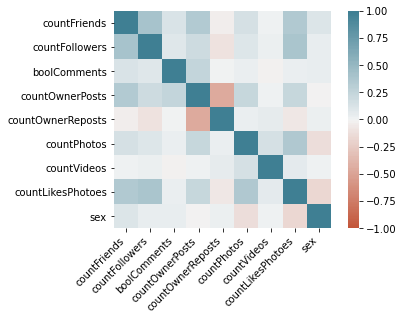

In [2]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Text(0.5, 1.0, 'countPhotos')

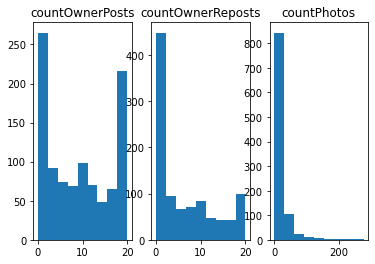

In [3]:
fig, axs = plt.subplots(1, 3)
n_bins = int(len(data) / 100)
axs[0].hist(data['countOwnerPosts'], bins=n_bins)
axs[0].set_title('countOwnerPosts')
axs[1].hist(data['countOwnerReposts'], bins=n_bins)
axs[1].set_title('countOwnerReposts')
axs[2].hist(data['countPhotos'], bins=n_bins)
axs[2].set_title('countPhotos')

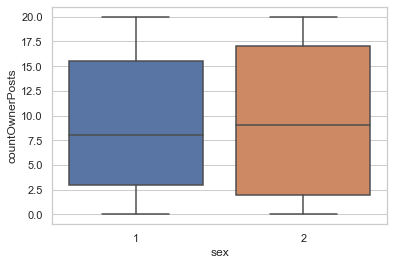

In [4]:
sns.set_theme(style="whitegrid")
ax_1 = sns.boxplot(x="sex", y="countOwnerPosts", data=data)

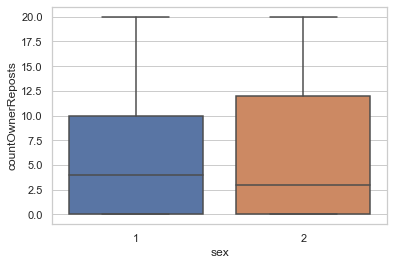

In [5]:
ax_2 = sns.boxplot(x="sex", y="countOwnerReposts", data=data)

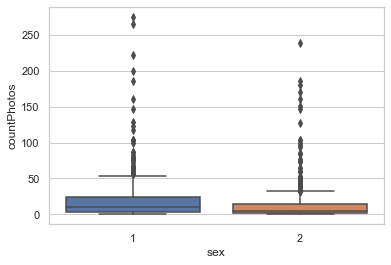

In [6]:
ax_3 = sns.boxplot(x="sex", y="countPhotos", data=data)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

allX = data.iloc[0:AmountOfSamples, 0:8]
allY = data.iloc[0:AmountOfSamples, 8]

allX.boolComments = allX.boolComments.astype('int64')

for i in range(AmountOfSamples):
    allY[i] =  allY[i] - 1
    
Xtrain, Xtest, Ytrain, Ytest = train_test_split(allX, allY, test_size=0.2)

scaler = preprocessing.MinMaxScaler()
Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain.values))
Xtest = pd.DataFrame(scaler.transform(Xtest.values))
print(Xtrain.shape)

(798, 8)


KNN

max -  uniform  -  18  -  0.7640449438202248
max -  distance  -  53  -  0.7605633802816901

For uniform 18

              precision    recall  f1-score   support

        male       0.69      0.43      0.53        82
      female       0.68      0.86      0.76       118

    accuracy                           0.69       200
   macro avg       0.69      0.65      0.65       200
weighted avg       0.69      0.69      0.67       200

Confusion Matrix:
[[ 35  47]
 [ 16 102]]

Wall time: 2.01 s


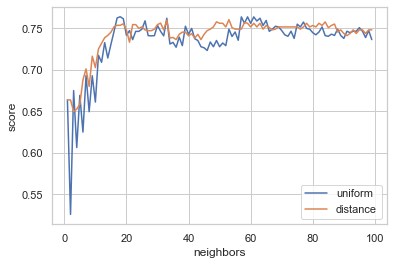

In [8]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

weights = ['uniform', 'distance']
best_w = weights[0]
best_score = 0
best_n = 1
for w in weights:
    results = []
    for n in range(1, 100):
        neigh = KNeighborsClassifier(n_neighbors=n, weights=w)
        neigh.fit(Xtrain, Ytrain)
        Ypred = neigh.predict(Xtest)
        results.append(f1_score(Ytest, Ypred))
    
    max_res = max(results)
    max_n = results.index(max(results)) + 1
    if max_res > best_score:
        best_w = w
        best_score = max_res
        best_n = max_n
    print('max - ', w, ' - ', max_n, " - ", max_res)
    graph = {'score': results, 'neighbors': range(1, 100)}
    df_graph = pd.DataFrame(data=graph)
    sns.lineplot(x="neighbors", y="score", data=df_graph, legend='brief', label=w)

print()
print('For', best_w, best_n)
print()
neigh = KNeighborsClassifier(n_neighbors=best_n, weights=best_w)
neigh.fit(Xtrain, Ytrain)
Ypred = neigh.predict(Xtest)
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()

Decision Tree

max -  5  -  0.8048780487804877

              precision    recall  f1-score   support

        male       0.72      0.59      0.64        82
      female       0.74      0.84      0.79       118

    accuracy                           0.73       200
   macro avg       0.73      0.71      0.72       200
weighted avg       0.73      0.73      0.73       200

Confusion Matrix:
[[48 34]
 [19 99]]

Wall time: 624 ms


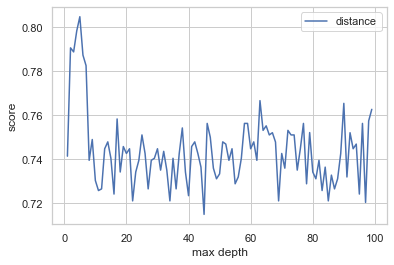

In [9]:
%%time
from sklearn import tree
import pydot

results = []
for n in range(1, 100):
    clf = tree.DecisionTreeClassifier(max_depth=n)
    clf = clf.fit(Xtrain, Ytrain)
    Ypred = clf.predict(Xtest)
    results.append(f1_score(Ytest, Ypred))

print('max - ', results.index(max(results)) + 1, " - ", max(results))
print()
graph = {'score': results, 'max depth': range(1, 100)}

df_graph = pd.DataFrame(data=graph)
sns.lineplot(x="max depth", y="score", data=df_graph, legend='brief', label=w)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()
# (graph_clf,) = pydot.graph_from_dot_data(tree.export_graphviz(clf))
# print()
# print(graph_clf)

SVM

In [10]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
print('Best params:')
gamma_range = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
parameters_1 = {'kernel':['rbf'], 'C':range(100, 1000, 100), 'gamma':gamma_range}
parameters_2 = {'kernel':['linear'], 'C':range(100, 1000, 50)}
svc = SVC()

clf = GridSearchCV(svc, parameters_1)
clf.fit(Xtrain, Ytrain)
print(clf.best_params_)
Ypred = clf.predict(Xtest)
print()
print('Best score rbf kernel')
print(f1_score(Ytest, Ypred))
print()
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()
print('=========================================================================')
print()
print('Best params:')
clf = GridSearchCV(svc, parameters_2)
clf.fit(Xtrain, Ytrain)
print(clf.best_params_)
Ypred = clf.predict(Xtest)
print()
print('Best score for linear kernel')
print(f1_score(Ytest, Ypred))
print()
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()

Best params:
{'C': 400, 'gamma': 1.0, 'kernel': 'rbf'}

Best score rbf kernel
0.769811320754717

              precision    recall  f1-score   support

        male       0.70      0.45      0.55        82
      female       0.69      0.86      0.77       118

    accuracy                           0.69       200
   macro avg       0.70      0.66      0.66       200
weighted avg       0.70      0.69      0.68       200

Confusion Matrix:
[[ 37  45]
 [ 16 102]]


Best params:
{'C': 750, 'kernel': 'linear'}

Best score for linear kernel
0.7758007117437724

              precision    recall  f1-score   support

        male       0.76      0.34      0.47        82
      female       0.67      0.92      0.78       118

    accuracy                           0.69       200
   macro avg       0.71      0.63      0.62       200
weighted avg       0.70      0.69      0.65       200

Confusion Matrix:
[[ 28  54]
 [  9 109]]

Wall time: 23.7 s


Random Forest

In [11]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
print('Best params:')
parameters = {'n_estimators':[50, 100],
              'criterion':['gini', 'entropy'],
              'max_depth':range(3, 9, 2),
              'min_samples_split':[2, 3, 4]}
rdfc = RandomForestClassifier()

clf = GridSearchCV(rdfc, parameters)
clf.fit(Xtrain, Ytrain)
print(clf.best_params_)
Ypred = clf.predict(Xtest)
print()
print('Best score')
print(f1_score(Ytest, Ypred))
print()
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()

Best params:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 3, 'n_estimators': 100}

Best score
0.796812749003984

              precision    recall  f1-score   support

        male       0.73      0.60      0.66        82
      female       0.75      0.85      0.80       118

    accuracy                           0.74       200
   macro avg       0.74      0.72      0.73       200
weighted avg       0.74      0.74      0.74       200

Confusion Matrix:
[[ 49  33]
 [ 18 100]]

Wall time: 19.6 s


AdaBoost

In [12]:
%%time
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
print('Best params:')
parameters = {'n_estimators':[50, 100],
              'learning_rate':[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]}
adbc = AdaBoostClassifier()

clf = GridSearchCV(adbc, parameters)
clf.fit(Xtrain, Ytrain)
print(clf.best_params_)
Ypred = clf.predict(Xtest)
print()
print('Best score')
print(f1_score(Ytest, Ypred))
print()
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()

Best params:
{'learning_rate': 0.2, 'n_estimators': 50}

Best score
0.7777777777777778

              precision    recall  f1-score   support

        male       0.70      0.56      0.62        82
      female       0.73      0.83      0.78       118

    accuracy                           0.72       200
   macro avg       0.71      0.70      0.70       200
weighted avg       0.72      0.72      0.71       200

Confusion Matrix:
[[46 36]
 [20 98]]

Wall time: 11.6 s


Gradient Boost

In [13]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
print('Best params:')
parameters = {'n_estimators':[10, 20, 30, 40, 50],
              'learning_rate':[0.4, 0.3, 0.2, 0.1, 0.05],
              'loss':['deviance', 'exponential'],
              'min_samples_split':[2, 3, 4]}
grbc = GradientBoostingClassifier()

clf = GridSearchCV(grbc, parameters)
clf.fit(Xtrain, Ytrain)
print(clf.best_params_)
Ypred = clf.predict(Xtest)
print()
print('Best score')
print(f1_score(Ytest, Ypred))
print()
print(classification_report(Ytest, Ypred, target_names=['male', 'female']))
print('Confusion Matrix:')
print(confusion_matrix(Ytest, Ypred, labels=[0, 1]))
print()

Best params:
{'learning_rate': 0.1, 'loss': 'exponential', 'min_samples_split': 3, 'n_estimators': 50}

Best score
0.7935222672064778

              precision    recall  f1-score   support

        male       0.72      0.62      0.67        82
      female       0.76      0.83      0.79       118

    accuracy                           0.74       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.74      0.74      0.74       200

Confusion Matrix:
[[51 31]
 [20 98]]

Wall time: 27.4 s
